In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from PIL import Image
from torchviz import make_dot
import os
%matplotlib inline
import pathlib

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8e31d4e6779b2755d38e32e3ee2a528eea8e35390fbcac61c51197f01051e941
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
!unzip '/content/drive/My Drive/Image_data/img_data2.zip'

Streaming output truncated to the last 5000 lines.
  inflating: all_img/train/15/2011_002756D3L0.jpeg  
  inflating: all_img/train/15/2009_000727D3L0.jpeg  
  inflating: all_img/train/15/2012_000980D3L0.jpeg  
  inflating: all_img/train/15/2008_001729D3L0.jpeg  
  inflating: all_img/train/15/2012_002758D3L0.jpeg  
  inflating: all_img/train/15/2012_001320D3L0.jpeg  
  inflating: all_img/train/15/2007_005114D3L0.jpeg  
  inflating: all_img/train/15/2011_000222D3L0.jpeg  
  inflating: all_img/train/15/2008_000009D3L0.jpeg  
  inflating: all_img/train/15/2008_005926D3L0.jpeg  
  inflating: all_img/train/15/2010_005432D3L0.jpeg  
  inflating: all_img/train/15/2009_002193D3L0.jpeg  
  inflating: all_img/train/15/2011_000502D3L0.jpeg  
  inflating: all_img/train/15/2011_005614D3L0.jpeg  
  inflating: all_img/train/15/2007_004190D3L0.jpeg  
  inflating: all_img/train/15/2008_003485D3L0.jpeg  
  inflating: all_img/train/15/2009_000854D3L0.jpeg  
  inflating: all_img/train/15/2009_002559D3L0.jp

In [ ]:
train_dir = pathlib.Path('/content/all_img/train') 
train_size = len(list(train_dir.glob('*/*.jpeg')))
print(train_size)

260310


###Preprocess Data

In [ ]:
data_dir = '/content/all_img'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
dataset = ImageFolder(data_dir+'/train', transform=transform)
dataset_test = ImageFolder(data_dir+'/test', transform=transform)

['train', 'test']
['21', '3', '9', '19', '23', '2', '22', '5', '15', '20', '16', '11', '14', '10', '7', '6', '18', '24', '8', '1', '13', '4', '0', '17', '25', '12', '26']


In [ ]:
random_seed = 2021
torch.manual_seed(random_seed)

val_size = int(train_size*0.1)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(236643, 23667)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""

        return len(self.dl)


In [ ]:
print(dataset.classes)
batch_size = 32
device = get_default_device()
print(device)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl =  DataLoader(dataset_test, batch_size*2, num_workers=4, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7', '8', '9']
cuda


In [ ]:
num_class = len(dataset.classes)
print(num_class)

27


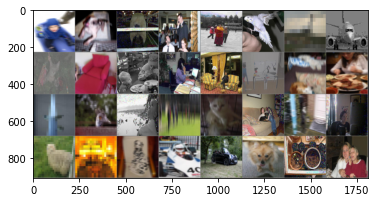

    1     8    17    21    23    17    11     2     6    14    25    19     0     7     8     4    20    15    12     8     8    26     1    17    20    16     1     4     5     4    12     5


In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class S_CNN(ImageClassificationBase):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        # conv layers: (in_channel size, out_channels size, kernel_size, stride, padding)

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 48, kernel_size=3, padding='same', stride = 1)
        self.conv1_bn=nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, padding=1, stride = 2)
        self.conv2_bn=nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(in_channels = 48, out_channels = 64, kernel_size=3, padding='same', stride = 1)
        self.conv3_bn=nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1, stride = 2)
        self.conv4_bn=nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding='same', stride = 1)
        self.conv5_bn=nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, padding=1, stride = 2)
        self.conv6_bn=nn.BatchNorm2d(64)
        self.conv7 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, padding='same', stride = 1)
        self.conv7_bn=nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding='same', stride = 1)
        self.conv8_bn=nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, padding=1, stride = 2)
        self.conv9_bn=nn.BatchNorm2d(128)
        

        # average pooling (kernel_size, stride)
        self.pool = nn.AdaptiveAvgPool2d((14, 14))

        # fully conected layers:
        self.fc1 = nn.Linear(14*14*128, 128)
        self.fc1_bn=nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.fc2_bn=nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, num_class)
        self.fc3_bn=nn.BatchNorm1d(num_class)

    def forward(self, x, training=True):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv5(x)
        x = F.relu(self.conv5_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv6(x)
        x = F.relu(self.conv6_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv7(x)
        x = F.relu(self.conv7_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv8(x)
        x = F.relu(self.conv8_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.conv9(x)
        x = F.relu(self.conv9_bn(x))
        # x = F.dropout(x, 0.2)
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = x.view(-1, 14 * 14 * 128)
        # print(x.shape)
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = F.dropout(x, 0.2)

        x = self.fc2(x)
        x = F.relu(self.fc2_bn(x))
        x = F.dropout(x, 0.2)

        x = self.fc3(x)
        x = F.relu(self.fc3_bn(x))
        x = F.dropout(x, 0.2)

        return x

    # def predict(self, x):
    #     # a function to predict the labels of a batch of inputs
    #     x = F.softmax(self.forward(x, training=False))
    #     return x

    # def accuracy(self, x, y):
    #     # a function to calculate the accuracy of label prediction for a batch of inputs
    #     #   x: a batch of inputs
    #     #   y: the true labels associated with x
    #     prediction = self.predict(x)
    #     maxs, indices = torch.max(prediction, 1)
    #     acc = 100 * torch.sum(torch.eq(indices.float(), y.float()).float())/y.size()[0]
    #     return acc.cpu().data[0]

In [ ]:
s_cnn = S_CNN(3, num_class).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(s_cnn.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
summary(s_cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 224, 224]           1,344
       BatchNorm2d-2         [-1, 48, 224, 224]              96
            Conv2d-3         [-1, 48, 112, 112]          20,784
       BatchNorm2d-4         [-1, 48, 112, 112]              96
            Conv2d-5         [-1, 64, 112, 112]          27,712
       BatchNorm2d-6         [-1, 64, 112, 112]             128
            Conv2d-7           [-1, 64, 56, 56]          36,928
       BatchNorm2d-8           [-1, 64, 56, 56]             128
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
           Conv2d-11           [-1, 64, 28, 28]          36,928
      BatchNorm2d-12           [-1, 64, 28, 28]             128
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,

In [ ]:
dataiter = iter(train_dl)
images, labels = next(dataiter)
yhat = s_cnn(images)
make_dot(yhat, params=dict(list(s_cnn.named_parameters()))).render("s_cnn", format="png")

's_cnn.png'

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(s_cnn, val_dl)]
history

[{'val_acc': 0.03736337274312973, 'val_loss': 3.2960364818573}]

In [ ]:
epochs = 30
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, s_cnn, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00007, train_loss: 2.2562, val_loss: 1.7366, val_acc: 0.4905
Epoch [1], last_lr: 0.00015, train_loss: 1.6863, val_loss: 1.4823, val_acc: 0.5658
Epoch [2], last_lr: 0.00028, train_loss: 1.5086, val_loss: 1.3360, val_acc: 0.6050
Epoch [3], last_lr: 0.00044, train_loss: 1.4279, val_loss: 1.4030, val_acc: 0.5860
Epoch [4], last_lr: 0.00060, train_loss: 1.3758, val_loss: 1.2518, val_acc: 0.6220
Epoch [5], last_lr: 0.00076, train_loss: 1.3447, val_loss: 1.2406, val_acc: 0.6257
Epoch [6], last_lr: 0.00089, train_loss: 1.3157, val_loss: 1.3167, val_acc: 0.6096
Epoch [7], last_lr: 0.00097, train_loss: 1.3085, val_loss: 1.2162, val_acc: 0.6322
Epoch [8], last_lr: 0.00100, train_loss: 1.2892, val_loss: 1.2164, val_acc: 0.6325
Epoch [9], last_lr: 0.00099, train_loss: 1.2847, val_loss: 1.1852, val_acc: 0.6387
Epoch [10], last_lr: 0.00098, train_loss: 1.2641, val_loss: 1.2379, val_acc: 0.6254
Epoch [11], last_lr: 0.00095, train_loss: 1.2601, val_loss: 1.2355, val_acc: 0.6337
Ep

In [ ]:
torch.save(s_cnn.state_dict(), '/content/drive/My Drive/Image_data/revised_model_13_10_2021_0.pth')

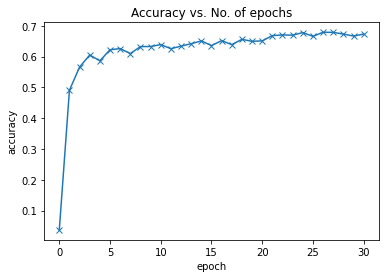

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

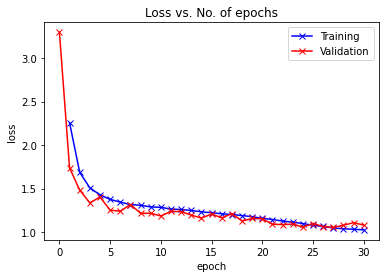

In [ ]:
plot_losses(history)